In [1]:
import pandas as pd
import numpy as np

## (a) Select a 2-class dataset with continuous nD features.

In [2]:
# Read iris.data, modify data to nD 2-class

def rf(fn):
    data = pd.read_csv(fn, sep=',', header=None, skipinitialspace=True)
    ncol= len(data.columns)-1
    mdata = data.loc[0:99, ]
    return mdata

## (b) Estimate the model parameters and compute a discriminant function based on the distribution in each class.

In [3]:
def getPrmtr(train_data,cnum):
    fnum = train_data.shape[1]-1
    m = np.zeros(cnum)
    mean = np.zeros((cnum, fnum))
    sigma = np.zeros((cnum, fnum,fnum))
    for i in range(0, cnum):
        subcls = train_data[train_data[4] == i+1]
        x=subcls.loc[:,:3]
        m[i] = len(x)
        mean[i]=x.mean()
    for j in range(0,len(train_data)):
        data = train_data.iloc[j]
        x = data[:fnum]
        y = data[4]
        temp = np.outer((x-mean[y-1]),(x-mean[y-1]))
        sigma[y-1] += temp/m[y-1]
    # for i in range(0,cnum):
    #     sigma[i] = sigma[i]/m[i]
        # t = (x-mean[y-2])
        # t1 = np.outer(t,t)
        # sigma[y-2] += t1
    return (mean, sigma, m ) # a = alphalist


    
fn = 'iris.data'
data = rf(fn)
print 'Read data iris.data'
print data.head()
temp = getPrmtr(data, 2)
print 'Means of two classes:'
print temp[0]
print 'Sigmas of two classes'
print temp[1]
print 'Alpha:'
print temp[2]

Read data iris.data
     0    1    2    3  4
0  5.1  3.5  1.4  0.2  1
1  4.9  3.0  1.4  0.2  1
2  4.7  3.2  1.3  0.2  1
3  4.6  3.1  1.5  0.2  1
4  5.0  3.6  1.4  0.2  1
Means of two classes:
[[ 5.006  3.418  1.464  0.244]
 [ 5.936  2.77   4.26   1.326]]
Sigmas of two classes
[[[ 0.121764  0.098292  0.015816  0.010336]
  [ 0.098292  0.142276  0.011448  0.011208]
  [ 0.015816  0.011448  0.029504  0.005584]
  [ 0.010336  0.011208  0.005584  0.011264]]

 [[ 0.261104  0.08348   0.17924   0.054664]
  [ 0.08348   0.0965    0.081     0.04038 ]
  [ 0.17924   0.081     0.2164    0.07164 ]
  [ 0.054664  0.04038   0.07164   0.038324]]]
Alpha:
[ 50.  50.]


D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### (c) Classify the examples and measure your error. Compute the confusion matrix, precision, recall,F-measure, and accuracy.

In [4]:
# K fold
def k_fold(size, k, shuffle = False):
    index = np.arange(0,size) 
    if shuffle:
        np.random.shuffle(index)
    index = np.reshape(index, (k,size/k))
#     print index
    test = []     
    train = []
    for i in range(0,k):
        test.append(index[i])
        temp = np.delete(index,i,0)
        train.append(temp.flatten())
    return test, train

In [5]:
# calculate the membership for one example x
from pylab import *
def calcm(x, a, m, s):
    ds = det(s)
    ins = inv(s)
    qf = dot((x-m).T,ins) 
    g = log(a)-0.5*log(ds)-0.5*np.dot(qf,(x-m))
    return g

    # det = np.linalg.det(s)
    # inv = np.linalg.inv(s)
    # prod = np.dot( (x-m).transpose(), inv )
    # t123 =  np.log(a)-0.5*np.dot(prod,(x-m))-np.log(det)

In [6]:
# given a test dataset value, return a list of claasifications
def classificaiton(data_test,al,ml,sl,threshold = 0):
    x_test = data_test.loc[:,:3]
    xnum = len(x_test)
    prelist = []

    for i in range(0, xnum):
        ex = x_test.iloc[i]
        c1 =  calcm(ex,al[0],ml[0],sl[0])
        c2 =  calcm(ex,al[1],ml[1],sl[1])
        if c1-c2<threshold:
            prelist.append(2)
        else:
            prelist.append(1)
    return prelist

In [7]:
def cMatrix(testdata,prelist):
    y_test= testdata[4].tolist() 
    cm = np.zeros((2,2))
    for i in range(0,len(y_test)):
        rl = y_test[i]
        pre = prelist[i]
        cm[rl-1][pre-1] +=1
    return cm

In [8]:
# Compute the confusion matrix, precision, recall,F-measure, and accuracy
def evalpf(cm):
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    Fm = 2*precision*recall/(precision+recall)
    return (precision,recall,Fm,accuracy)

In [9]:
def clsmain(fn='iris.data', kfold = 5, classnum = 2, shuffle = True):
    data = rf(fn)
    total = len(data)
    i_test, i_train = k_fold(total,kfold,True)
    prelist = []
    data_test =data.iloc[i_test[0],]
    data_train=data.iloc[i_train[0],]
    parms = getPrmtr(data_train,classnum)  #(mean, sigma/mean, m )
    trainnum = len(data_train)
    alfa = parms[2]/trainnum
    y_predict = classificaiton(data_test, alfa, parms[0], parms[1])
    cm = cMatrix(data_test,y_predict)
    print 'confusion matrix is '
    print cm
    result = evalpf(cm)
    print 'result of precision, recall,F-measure, and accuracy are'
    print result

clsmain()

confusion matrix is 
[[  7.   0.]
 [  0.  13.]]
result of precision, recall,F-measure, and accuracy are
(1.0, 1.0, 1.0, 1.0)


D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The confusion matrix shows that there are 8 test cases in class 1, and 12 test cases in class 2. Depending on trainning classifier function, all test cases fit the calssifier function.

## (d) Plot the precision-recall curve and measure the area under curve.

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


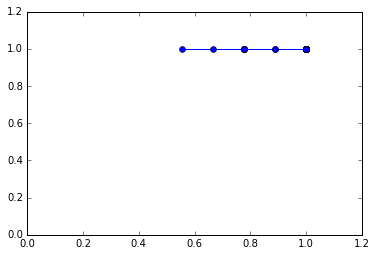

Auc 0.444444444444


In [18]:
def plot(fn='iris.data', kfold = 5, classnum = 2, shuffle = True,threshold = 0):
    data = rf(fn)
    total = len(data)
    i_test, i_train = k_fold(total,kfold,True)
    data_test =data.iloc[i_test[0],]
    data_train=data.iloc[i_train[0],]
    parms = getPrmtr(data_train,classnum)  #(mean, sigma/mean, m )
    trainnum = len(data_train)
    alfa = parms[2]/trainnum
    pnum =len(threshold)
    preth = []
    result = np.zeros((pnum,4))
    for i in range(0,pnum):
        p = classificaiton(data_test, alfa, parms[0], parms[1],threshold[i]) #prelist
        preth.append(p)
        cm = cMatrix(data_test,p)
        result[i]= evalpf(cm)  # (precision,recall,Fm,accuracy)

    # Plot Precision-Recall curve
    px = result[:,0]
    py = result[:,1]
    plt.plot(px, py, 'bo-', label='Precision-Recall curve')
    plt.axis([0.0, 1.2, 0.0, 1.2])
    plt.show()
    # print auc(result)
    area = 0.0

    area = metrics.auc(px, py)
    print 'Auc', area
    
th = np.arange(-50,50,1.5)
plot(threshold=th)

I tried threshold frome(-10,10), (-50,50),(-100,50)and (-50,100), all Prediction-Recall curves look like a line of y = 1.0